<img src="assets/images/banner.jpg" alt="banner" style="background-color: #ecf0f1; border-radius: 5px; text-align:center; color:#080205; font-weight:800; text-shadow: 2px 2px 2px #888888;">

<div style="padding: 10px; border-radius: 5px; color:#080205; font-family: 'Times New Roman', Times, serif;">
    <h1 style="font-weight:800; font-size:30px;">Introduction</h1>
    Alzheimer's disease is a complex neurodegenerative disorder that affects millions of people worldwide. Early detection and prediction of Alzheimer's can lead to better management and treatment outcomes. This prediction system utilizes a machine learning model trained on a dataset of relevant features to provide predictions about the likelihood of Alzheimer's disease.
    <h1 style="font-weight:800; font-size:30px;">About Alzheimer's Disease</h1>
    Alzheimer's disease (AD) is a progressive neurodegenerative disease. Though best known for its role in declining memory function, symptoms also include: difficulty thinking and reasoning, making judgements and decisions, and planning and performing familiar tasks. It may also cause alterations in personality and behavior. The cause of AD is not well understood. There is thought to be a significant hereditary component. For example, a variation of the APOE gene, APOE e4, increases risk of Alzheimer's disease.
    <h1 style="font-weight:800; font-size:30px;">Purpose of the project</h1>
    The purpose of this project proposal is to develop a machine learning model for the early prediction of Alzheimer's disease. Alzheimer's disease is a devastating neurodegenerative disorder that affects millions of individuals worldwide. Early detection is crucial for better patient care and the development of potential interventions. This project aims to leverage machine learning techniques to create a predictive model that can identify individuals at risk of Alzheimer's disease based on relevant data.
    <h1 style="font-weight:800; font-size:30px;">Potential Impact</h1>
    The potential impact of this project on the issue of Alzheimer's disease is significant:
    - Early prediction of Alzheimer's disease can lead to timely interventions, potentially slowing down the progression of the disease.
    - Accurate prediction models can aid in identifying suitable candidates for clinical trials and research studies.
    - Providing a tool for early prediction can raise awareness about Alzheimer's disease and encourage individuals to seek early medical evaluation.
    <br><br>
    The model will be trained on a dataset collected from <a href="https://adni.loni.usc.edu/">Alzheimer’s Disease Neuroimaging Initiative (ADNI)</a>. This dataset is a comprehensive collection of clinical, imaging, and genetic data from individuals with Alzheimer's disease.
</div>

<h2 style="color: #000; font-family: 'Times New Roman', Times, serif;"><b>Variable Descriptions</b></h2>
<table style="color: #000; width: 100%; border-collapse: collapse; margin-bottom: 20px;">
    <tr>
        <th style="color: #fff; background-color: #080205; border: 1px solid #fff; padding: 8px; text-align: left;">Variable</th>
        <th style="color: #fff; background-color: #080205; border: 1px solid #fff; padding: 8px; text-align: left;">Description</th>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">index</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">A numerical index for each row in the dataframe.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">directory.id</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">A unique identifier for each row in the dataframe.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Subject</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">A unique identifier for each subject in the dataframe.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">RID</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">A numerical identifier for each subject in the dataframe.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">image.data.id</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">A numerical identifier for each image in the dataframe.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Modality</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The type of imaging used to collect the data (MRI).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Visit</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The visit number associated with the data.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Acq.Date</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The date on which the data was acquired.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">DX.bl</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The diagnosis at baseline (AD, LMCI, or CN).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">EXAMDATE</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The date of the exam associated with the data.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">AGE</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The age of the subject at the time of the exam.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">PTGENDER</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The gender of the subject.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">PTEDUCAT</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The educational level of the subject.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">PTETHCAT</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The ethnicity of the subject (Hisp/Latino or Not Hisp/Latino).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">PTRACCAT</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The race of the subject (White).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">APOE4</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The APOE4 genotype of the subject (0, 1, or 2).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">MMSE</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The Mini-Mental State Examination score of the subject.</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">imputed_genotype</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Whether or not the genotype was imputed (True or False).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">APOE Genotype</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The APOE genotype of the subject (3,3; 3,4; 4,3; 4,4).</td>
    </tr>
    <tr>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">Dx Codes for Submission</td>
        <td style="border: 1px solid #fff; padding: 8px; text-align: left;">The diagnosis code for submission (AD, MCI, or CN).</td>
    </tr>
</table>

<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Importing the libraries
</h1>

In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
data = pd.read_csv('data/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Preprocessing
</h1>

<div style="text-align:center; color:black; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Checking for NULL values
</div>

In [4]:
data.isnull().sum()

directory.id               0
Subject                    0
RID                        0
Image.Data.ID              0
Modality                   0
Visit                      0
Acq.Date                   0
DX.bl                      0
EXAMDATE                   0
AGE                        0
PTGENDER                   0
PTEDUCAT                   0
PTETHCAT                   0
PTRACCAT                   0
APOE4                      0
MMSE                       0
imputed_genotype           1
APOE Genotype              0
Dx Codes for Submission    0
dtype: int64

<div style="text-align:center; color:black; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Deleting NULL values
</div>

In [5]:
data = data.dropna()
data.isnull().sum().sum()

0

In [6]:
data.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,09-01-2005,AD,09-12-2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11-08-2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,09-02-2005,CN,09-07-2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


<div style="text-align:center; color:black; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Declaring Features (X) and Target (y) columns
</div>

In [7]:
X = data
Y = data['DX.bl']
# del data

remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Exploratory Data Analysis (EDA)
</h1>

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.5em;">
    Relationship between age and diagnosis (DX.bl) by plotting a scatterplot of age against diagnosis.
</div>

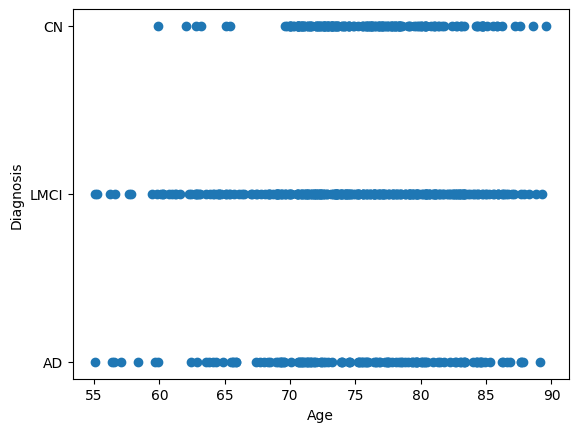

In [8]:
plt.scatter(data['AGE'], data['DX.bl'])

plt.xlabel('Age')
plt.ylabel('Diagnosis')

plt.show()

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Counts of gender and ethnicity across different diagnoses
</div>

In [9]:
gender_ethnicity_counts = data.groupby(['DX.bl', 'PTGENDER', 'PTETHCAT']).size().reset_index(name='count')
print(gender_ethnicity_counts)

   DX.bl PTGENDER         PTETHCAT  count
0     AD   Female  Not Hisp/Latino     64
1     AD   Female          Unknown      1
2     AD     Male  Not Hisp/Latino     68
3     CN   Female      Hisp/Latino      2
4     CN   Female  Not Hisp/Latino     89
5     CN   Female          Unknown      1
6     CN     Male  Not Hisp/Latino     98
7   LMCI   Female      Hisp/Latino      4
8   LMCI   Female  Not Hisp/Latino    102
9   LMCI   Female          Unknown      1
10  LMCI     Male      Hisp/Latino      2
11  LMCI     Male  Not Hisp/Latino    195


<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Relationship between APOE4 genotype and diagnosis (DX.bl)
</div>

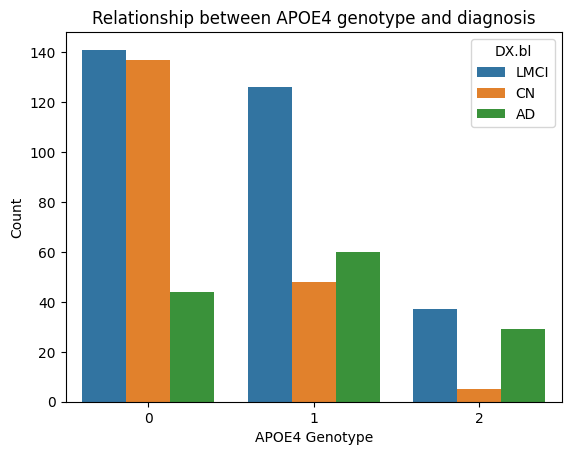

In [10]:
sns.countplot(x='APOE4', hue='DX.bl', data=data)
plt.title('Relationship between APOE4 genotype and diagnosis')
plt.xlabel('APOE4 Genotype')
plt.ylabel('Count')
plt.show()

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Scatterplot of MMSE score against diagnosis
</div>

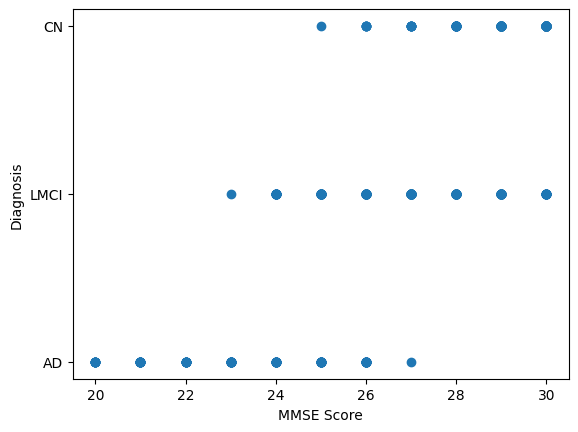

In [11]:
plt.scatter(data['MMSE'], data['DX.bl'])

plt.xlabel('MMSE Score')
plt.ylabel('Diagnosis')

plt.show()

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Plotting the counts of imputed genotype (imputed_genotype) across different diagnoses (DX.bl)
</div>

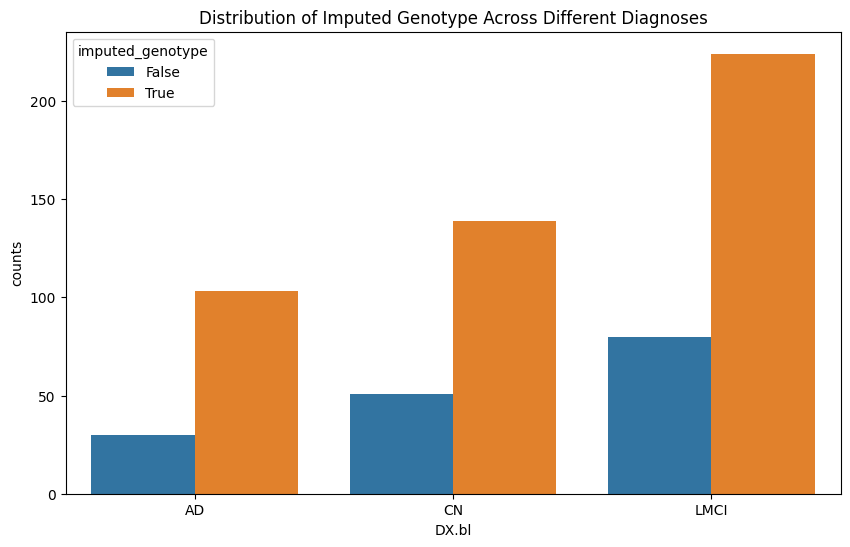

In [12]:
counts = data.groupby(['DX.bl', 'imputed_genotype']).size().reset_index(name='counts')

plt.figure(figsize=(10,6))
ax = sns.barplot(x="DX.bl", y="counts", hue="imputed_genotype", data=counts)
ax.set_title('Distribution of Imputed Genotype Across Different Diagnoses')
plt.show()

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.5em;">
    Relationship between APOE Genotype and diagnosis (DX.bl) by plotting a bar chart of APOE Genotype against diagnosis.
</div>

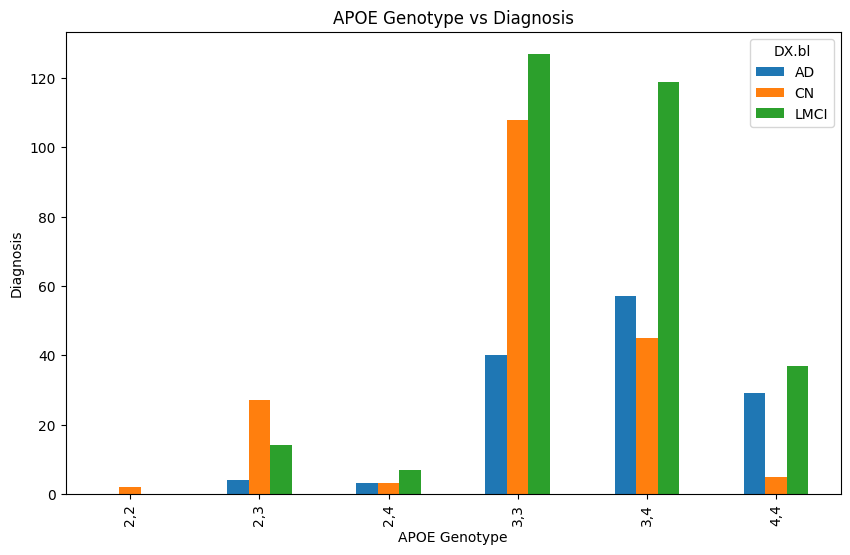

In [13]:
ax = data.groupby(['APOE Genotype', 'DX.bl']).size().unstack().plot(kind='bar', figsize=(10,6))

ax.set_title('APOE Genotype vs Diagnosis')
ax.set_xlabel('APOE Genotype')
ax.set_ylabel('Diagnosis')

plt.show()

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Categorical Variable Distributions
</div>

In [14]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of PTGENDER
Male      363
Female    264
Name: PTGENDER, dtype: int64

Distribution of APOE4
0    322
1    234
2     71
Name: APOE4, dtype: int64

Distribution of PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64

Distribution of imputed_genotype
True     466
False    161
Name: imputed_genotype, dtype: int64

Distribution of APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

Distribution of PTRACCAT
White    583
Black     31
Asian     13
Name: PTRACCAT, dtype: int64


<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Numerical Variable Distributions
</div>

Numerical Var Distributions:



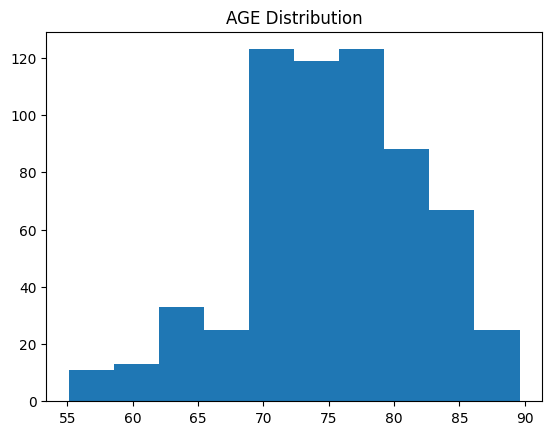

count    627.000000
mean      75.161882
std        6.689979
min       55.100000
25%       71.200000
50%       75.400000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


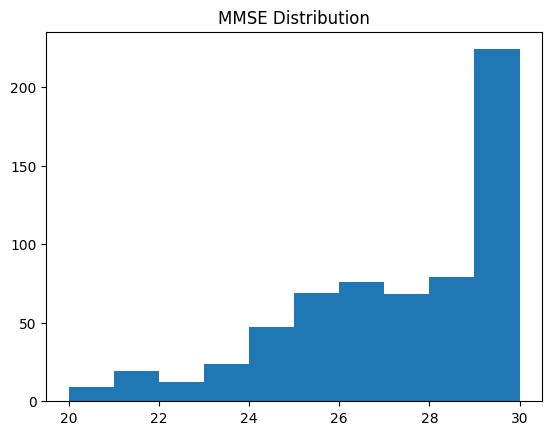

count    627.000000
mean      26.921850
std        2.563934
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


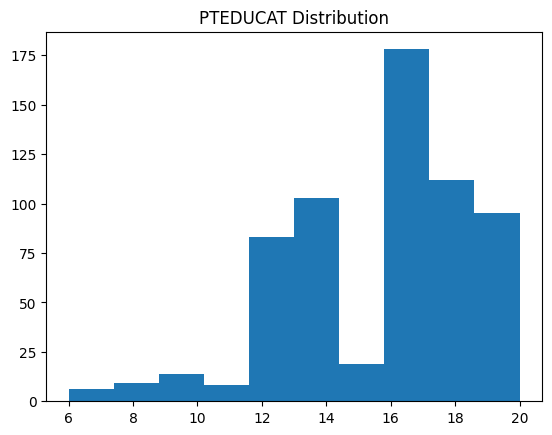

count    627.000000
mean      15.612440
std        2.978845
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


In [15]:
print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    print(X[var].describe())

<!-- <p style="color: #3498db; font-size: 18px; font-weight: bold;">Stylish Text 1</p>
<p style="font-family: 'Courier New', monospace; font-size: 20px; color: #2ecc71;">Stylish Text 2</p>
<p style="text-transform: uppercase; letter-spacing: 2px; font-size: 16px; color: #e74c3c;">Stylish Text 3</p>
<p style="font-style: italic; font-size: 22px; color: #f39c12;">Stylish Text 4</p>
<p style="text-decoration: underline; font-size: 18px; color: #9b59b6;">Stylish Text 5</p>
<p style="font-family: 'Times New Roman', serif; font-size: 24px; color: #34495e;">Stylish Text 6</p>
<p style="font-weight: 700; font-size: 20px; color: #1abc9c;">Stylish Text 8</p>
<p style="text-shadow: 2px 2px 4px #888888; font-size: 18px; color: #c0392b;">Stylish Text 9</p>
<p style="font-size: 22px; color: #3498db; transform: rotate(15deg);">Stylish Text 10</p> -->

<div style="text-align:center; color:orange; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 1.7em;">
    Analyzing target (y) distribution
</div>

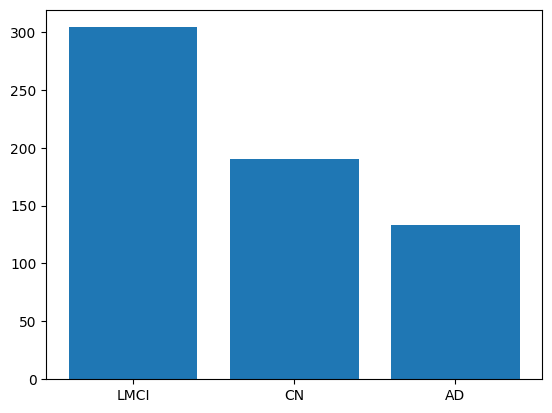

In [16]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Preprocessing
</h1>

<div style="text-align:center; color:yellow; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2em;">
    Converting the Categorical Variables to 1-Hot
</div>

In [17]:
for var in cat_vars:
    print(f'Converting {var} to 1-hot encoding')
    one_hot_df = pd.get_dummies(X[var], prefix=var)
    X = pd.concat([X, one_hot_df], axis=1)
    X.drop(var, axis=1, inplace=True)
    
X.head(4)

Converting PTGENDER to 1-hot encoding
Converting APOE4 to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting imputed_genotype to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTRACCAT to 1-hot encoding


,AGE,PTEDUCAT,MMSE,PTGENDER_Female,PTGENDER_Male,APOE4_0,APOE4_1,APOE4_2,PTETHCAT_Hisp/Latino,PTETHCAT_Not Hisp/Latino,...,imputed_genotype_True,"APOE Genotype_2,2","APOE Genotype_2,3","APOE Genotype_2,4","APOE Genotype_3,3","APOE Genotype_3,4","APOE Genotype_4,4",PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_White
0,81.3,18,20,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1
1,67.5,10,27,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,73.7,16,29,0,1,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
3,80.4,13,25,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


<div style="text-align:center; color:yellow; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2em;">
    Normalization function
</div>

In [18]:
def normalize(X):
    X = np.array(X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    normalized_X = (X - means) / stds

    print('Normalizing:')
    for i, (mean, std) in enumerate(zip(means, stds)):
        print(f'  Variable {i+1}: Mean = {mean:.2f}, Standard Deviation = {std:.2f}')

    return normalized_X

<div style="text-align:center; color:yellow; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2em;">
    Splitting the dataset
</div>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

num_test = X_test.shape[0]

<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Comparing between models
</h1>

In [20]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

### Checking each model's accuracy

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Linear Discriminant Analysis
</div>

Cross Validation: 68.45%
Accuracy: 73.81%
Precision: 74.55%
Recall: 73.81%
F1 Score: 73.96%
Confusion Matrix:


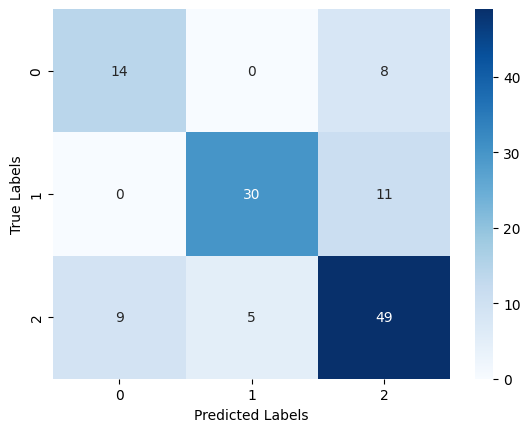

In [21]:
lda_clf = LinearDiscriminantAnalysis(solver='svd', store_covariance=False, tol=0.0001)
lda_clf.fit(X_train, y_train)

y_pred = lda_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(lda_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Logistic Regression
</div>

Cross Validation: 69.85%
Accuracy: 71.43%
Precision: 71.95%
Recall: 71.43%
F1 Score: 71.60%
Confusion Matrix:


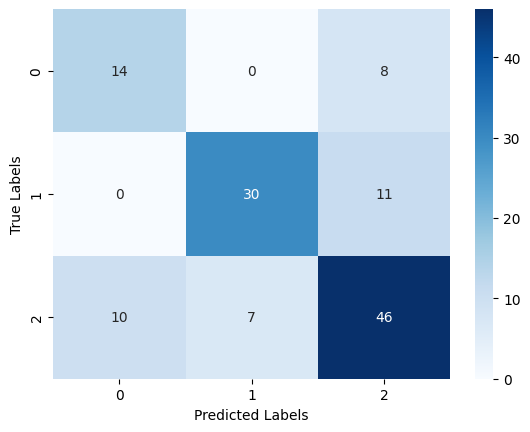

In [22]:
log_clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000000, multi_class='multinomial')
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(log_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Random Forest Classifier
</div>

Cross Validation: 63.47%
Accuracy: 60.32%
Precision: 60.73%
Recall: 60.32%
F1 Score: 60.26%
Confusion Matrix:


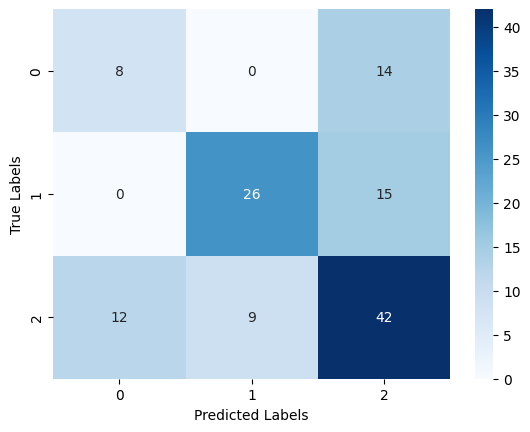

In [23]:
rf_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                criterion='gini', max_depth=None, max_features='sqrt',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0, min_samples_leaf=1,
                                min_samples_split=2, min_weight_fraction_leaf=0.0,
                                n_estimators=100, n_jobs=-1, oob_score=False,
                                random_state=123, verbose=0, warm_start=False)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(rf_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Ridge Classifier
</div>

Cross Validation: 63.07%
Accuracy: 67.46%
Precision: 67.98%
Recall: 67.46%
F1 Score: 67.45%
Confusion Matrix:


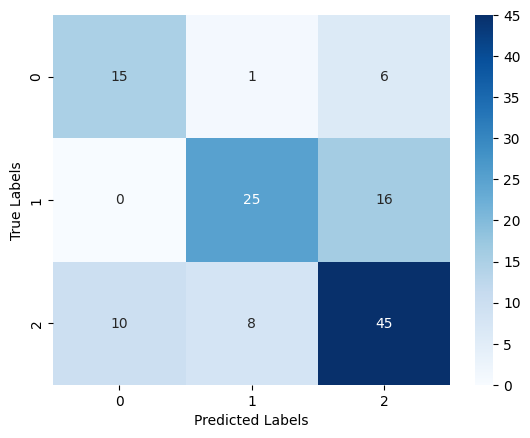

In [24]:
rg_clf = RidgeClassifier(alpha=1.0, copy_X=True, fit_intercept=True, random_state=123, solver='auto', tol=0.0001)
rg_clf.fit(X_train, y_train)

y_pred = rg_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(rg_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Gradient Boosting Classifier
</div>

Cross Validation: 66.26%
Accuracy: 64.29%
Precision: 64.97%
Recall: 64.29%
F1 Score: 64.48%
Confusion Matrix:


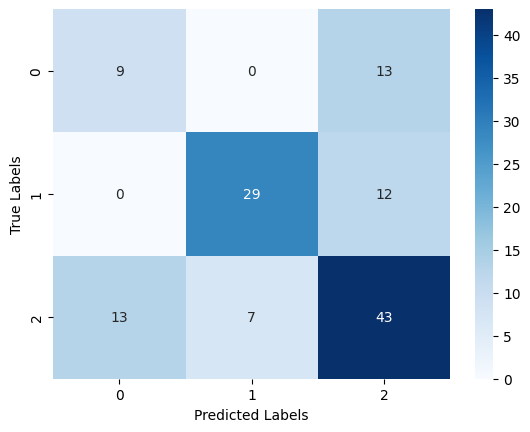

In [25]:
gb_clf = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=123, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)

gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(gb_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Multi-layer Perceptron (MLP) Classifier
</div>

Cross Validation: 49.48%
Accuracy: 68.25%
Precision: 70.75%
Recall: 68.25%
F1 Score: 67.24%
Confusion Matrix:


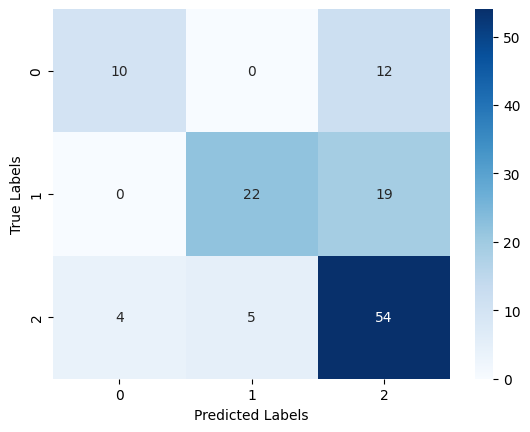

In [26]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(15, 10), alpha=3, learning_rate='adaptive', max_iter=100000)
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

print('Cross Validation:', format(cross_val_score(mlp_clf, X_train, y_train, cv=5).mean(), '.2%'))
print('Accuracy:', format(accuracy_score(y_test, y_pred), '.2%'))
print('Precision:', format(precision_score(y_test, y_pred, average='weighted'), '.2%'))
print('Recall:', format(recall_score(y_test, y_pred, average='weighted'), '.2%'))
print('F1 Score:', format(f1_score(y_test, y_pred, average='weighted'), '.2%'))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div style="text-align:center; color:lightgreen; font-weight:600; font-family: 'Courier New', Times, serif; font-size: 2.0em;">
    Conclusion
</div>

<!-- <center>
  <table>
    <thead>
      <tr>
        <th>Model</th>
        <th>Cross Val</th>
        <th>Accuracy</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Linear Discriminant Analysis</td>
        <td>69.86</td>
        <td>66.67</td>
        <td>67.52</td>
        <td>66.67</td>
        <td>66.62</td>
      </tr>
      <tr style="background-color: green;">
        <td>Logistic Regression</td>
        <td>70.66</td>
        <td>68.25</td>
        <td>68.63</td>
        <td>68.25</td>
        <td>68.12</td>
      </tr>
      <tr>
        <td>Random Forest Classifier</td>
        <td>65.66</td>
        <td>64.29</td>
        <td>63.94</td>
        <td>64.29</td>
        <td>63.87</td>
      </tr>
      <tr>
        <td>Ridge Classifier</td>
        <td>64.87</td>
        <td>63.49</td>
        <td>65.01</td>
        <td>63.49</td>
        <td>63.51</td>
      </tr>
      <tr>
        <td>Gradient Boosting Classifier</td>
        <td>66.27</td>
        <td>64.29</td>
        <td>65.17</td>
        <td>64.29</td>
        <td>64.07</td>
      </tr>
      <tr>
        <td>MLP Classifier</td>
        <td>51.28</td>
        <td>63.29</td>
        <td>63.61</td>
        <td>63.49</td>
        <td>62.97</td>
      </tr>
    </tbody>
  </table>
</center> -->

Choosing Logistic Regression with validation Score .67

<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Model Selection
</h1>

### Testing Logistic Regression Model

In [27]:
log_clf_preds = log_clf.predict(X_test)
    
log_clf_accuracy = (log_clf_preds == y_test)
print('Test Accuracy =', format( np.sum(log_clf_accuracy)/num_test, '.2%'))

Test Accuracy = 71.43%


<h1 style="background-color: #080205; padding: 10px; border-radius: 5px; text-align:center; color:#ecf0f1; font-weight:600; text-shadow: 2px 2px 2px #888888;">
    Exporting the final model
</h1>

In [28]:
joblib.dump(log_clf, 'model/alzheimer_model.pkl')

['model/alzheimer_model.pkl']